## Final Assignment - Intrusion detection

### Introduction 
Security is an important issue in today's environments.  
An intrusion detection system (IDS) is a model that can be used to analyze anomalous behavior in a network. NSL-KDD is the updated version of KDD cup 99 dataset. It is used as a benchmark for researchers  to compare different types of Intrusion detection system (IDS) methods or build an intrusion detection system.  
An in depth analysis of the original dataset can be found on these [Tavallaee et al.](https://www.researchgate.net/publication/48446353_A_detailed_analysis_of_the_KDD_CUP_99_data_set) and [Rawat et al.](https://arxiv.org/abs/1910.01114) papers.

In [1]:
# if needed install packages uncommenting the following commands (omit the --no-use if not running on windows)
# !pip install hdbscan --no-use-pep517
# !pip install yellowbrick

In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import hdbscan
# from fastcluster import linkage
from yellowbrick.cluster import KElbowVisualizer
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# load the data
train_df = pd.read_csv('NSL-KDDTrain.csv')
test_df = pd.read_csv('NSL-KDDTest.csv')

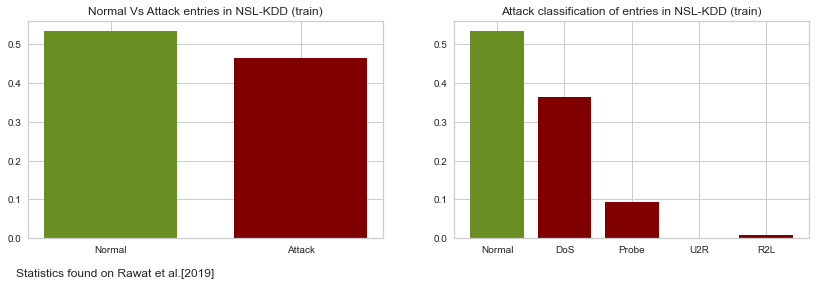

In [4]:
# create graphs based on the statistics found on the aforementioned papers
normal_attack = ['Normal', 'Attack']
normal_attack_height = [67343/train_df.shape[0], (train_df.shape[0]-67347)/train_df.shape[0]]

attack_type = ['Normal', 'DoS', 'Probe', 'U2R', 'R2L']
attack_type_height = [67343/train_df.shape[0], 45927/train_df.shape[0], 11656/train_df.shape[0], 52/train_df.shape[0] , 995/train_df.shape[0]]

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.bar(x=normal_attack, height=normal_attack_height, width=0.7, color=['olivedrab','maroon'])
plt.title('Normal Vs Attack entries in NSL-KDD (train)')
plt.text(x=-0.5, y=-0.1, s='Statistics found on Rawat et al.[2019]', fontsize=12)

plt.subplot(122)
plt.bar(x=attack_type, height=attack_type_height, color=['olivedrab'] + ['maroon']*4)
plt.title('Attack classification of entries in NSL-KDD (train)');

As suggested by the information presented in the graphs above, there is approximately the same number of attack and normal labels.   
So, to tackle the problem in an unlabel manner, **clustering** techniques are suitable. Techniques that cluster the data either into two or five clusters should be prefered (interpreted as _attack vs normal_ or _normal vs attack type_). However, there could be multiple clusters, that "explain" a different partition of the data.  

In [5]:
# search for missing values
if train_df.isnull().any().sum() > 0:
    print('There are missing values in the data.')
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


There are three different types of attribuutes
* Floats
* Integers
* Character

In [6]:
# split the dataset into numeric and categorical variables
cat_columns = [col for col, dtype in zip(train_df.columns, train_df.dtypes=='object') if dtype]

train_df_num = train_df[[col for col in train_df.columns if col not in cat_columns]]
train_df_cat = train_df[cat_columns]

# do the same for the test set, keep seperate the target variable
test_df_num = test_df[[col for col in train_df.columns if col not in cat_columns]]
test_df_cat = test_df[cat_columns]
y = test_df['target']

### KMeans
KMeans is one of the most well know clustering techniques.  
Kmeans algorithm is an iterative algorithm that tries to split the dataset into K pre-determined (user defined) distinct non-overlapping number of clusters (subgroups) where each data point belongs to only one group.   
It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible.   
It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.  
**Drawbacks**  
k-means is limited to linear cluster boundaries and will often be ineffective if the clusters have complicated geometries. More info [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).  
There are more "elegant" techniques that do overcome this issue (for example DBSCAN) but they are a lot more computationaly expensive and they will not be implemented in this workbook.

KMeans calculated the distance between clusters, so it is always prefered to scale the data before doing any clustering.

In [7]:
scaler = StandardScaler()
train_df_num_scaled = scaler.fit_transform(train_df_num)
test_df_num_scaled = scaler.transform(test_df_num)

In [8]:
# generate the clusters
clusterer = KMeans(n_clusters=2, random_state=512)
# fit model and predict clusters
clusterer.fit(train_df_num_scaled)
yhat = clusterer.predict(test_df_num_scaled)

In [9]:
y_act_int = [1 if x=='attack' else 0 for x in y]

In [10]:
print(classification_report(y_act_int, yhat))

              precision    recall  f1-score   support

           0       0.62      0.98      0.76      9711
           1       0.97      0.55      0.70     12833

    accuracy                           0.73     22544
   macro avg       0.80      0.76      0.73     22544
weighted avg       0.82      0.73      0.73     22544



Above, we have selected 2 clusters, as we want to classify entries as either normal or attack.  
However, in unsupervised methods, we generally do not know the optimal number of clusters. There are various techniques that are used that try to find that number K, based on different criterions.  
A good overview of the most common methods is found [here](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad).  
It needs to be noted that it it usual to test with multiple methods, and select K that is the most common between all methods.  
Here, I will be using the elbow method.


The **elbow method** is used to determine the number of clusters K. The clustering algorithm is run multiple times, for an increasing number of cluster choice. The clustering score is then plotted as a function of the number of clusters.  
If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

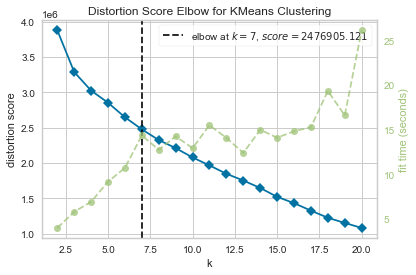

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
clusterer = KMeans(random_state=512)
visualizer = KElbowVisualizer(clusterer, k=(2,21))
visualizer.fit(train_df_num_scaled)
visualizer.show() 

In the graph, **7** is shown as the optimal number of clusters. However, it is not very clear, as **11** could be considered another good K (based on distortion score).    
But, since the test set is labeled, I will be running results of clusters around 7 (range 4-12) and plotting the resulting accuracy on the test set.

Since the test set has data classified into two classes, normal and attack an approach needs to be followed on how a cluster is considered to represent the attack or normal class. For the purpose of this project, since I have no domain expertise to be able to interpret the clusters, a cluster is considered to represent the attack class, if most entries of the cluster from the test set are in attack class and normal otherwise.

In [12]:
def kmean_accuracy_at_k(min_k, max_k, train_df, test_df, y_act):
    accuracy_per_k = []

    for k in tqdm(range(min_k, max_k)):
        clust = KMeans(n_clusters=k, random_state=512, init='k-means++')
        clust.fit(train_df)
        yhat = clust.predict(test_df)

        # define the class that each cluster represents
        pred_class = [np.nan]*len(y_act)
        for n in range(k):
            cluster=[x if x==n else np.nan for x in yhat]
            clust_values = [x for x,y in zip(y_act, cluster) if y==n]
            n_attacks = sum(clust_values)
            n_normal = len(clust_values) - n_attacks

            if n_attacks >= n_normal:
                cluster = [1 if x==n else x for x in cluster]
            else:
                cluster = [0 if x==n else x for x in cluster]

            # update the predicted class
            pred_class = np.nansum([pred_class, cluster], axis=0)

        accuracy_per_k.append(accuracy_score(y_act, pred_class))

    return accuracy_per_k

Use **all numeric features**, with different scalling

In [13]:
acc_zscaled_all_num = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_num_scaled , test_df=test_df_num_scaled, y_act=y_act_int)

100%|██████████| 9/9 [01:37<00:00, 10.86s/it]


In [14]:
scaler = MinMaxScaler()
train_df_num_scaled = scaler.fit_transform(train_df_num)
test_df_num_scaled = scaler.transform(test_df_num)

In [15]:
acc_mmscaled_all_num = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_num_scaled , test_df=test_df_num_scaled, y_act=y_act_int)

100%|██████████| 9/9 [00:56<00:00,  6.28s/it]


In [16]:
def plot_accuracies(min_k, max_k, accu_list, label_list):
    color_list = ['firebrick', 'steelblue', 'forestgreen']
    pch_list = ['-.', '--', '-']
    plt.figure(figsize=(12,5))
    for acc, acc_label, acc_color, acc_pch in zip(accu_list, label_list, color_list, pch_list):
        plt.plot(range(min_k, max_k), acc, acc_pch, color=acc_color, label=acc_label)
    #plt.plot(range(4,13), acc_zscaled_all_num, '-.', color='firebrick', label='Standard Scaled')
    #plt.plot(range(4,13), acc_mmscaled_all_num, '--', color='steelblue', label='Min-Max Scaled')
    plt.legend()
    plt.xlabel('Number of clusters K')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy score per number of clusters')
    plt.show()


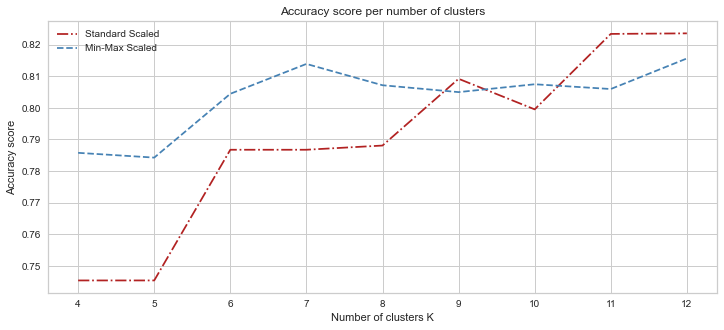

In [17]:
plot_accuracies(4, 13, [acc_zscaled_all_num, acc_mmscaled_all_num], ['Standard Scaled', 'Min-Max Scaled'])

Use all numeric features, but with **dimensionality reduction**.

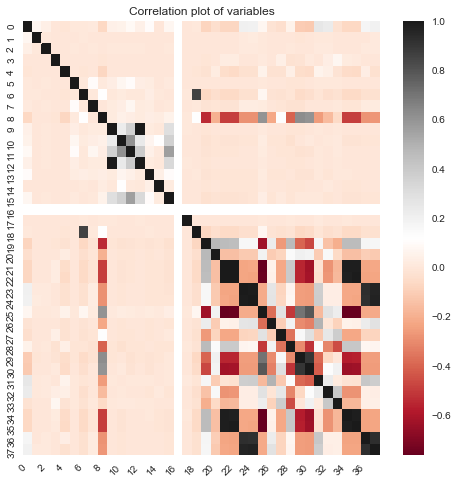

In [18]:
corr_df = pd.DataFrame(train_df_num_scaled).corr()

plt.figure(figsize=(8,8))
ax = sns.heatmap(
      corr_df, 
      cmap='RdGy'
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Correlation plot of variables');

Some of the variables are highly correlated with each other.  
We can reduce the dimensions of the dataset using a dimensionality reduction technique such as SVD.

In [19]:
def sing_values_train_test(n_comp, train_df, test_df):
    
    svd = TruncatedSVD(n_components=n_comp)
    train_df_svd = svd.fit_transform(train_df)
    test_df_svd = svd.transform(test_df)

    explained_variance = svd.explained_variance_ratio_.sum()
    print(f'Explained variance ratio of {n_comp} components: {explained_variance*100:.2f}%')

    return train_df_svd, test_df_svd

In [21]:
train_df_svd_30, test_df_svd_30 = sing_values_train_test(30, train_df_num_scaled, test_df_num_scaled)
train_df_svd_20, test_df_svd_20 = sing_values_train_test(20, train_df_num_scaled, test_df_num_scaled)
train_df_svd_15, test_df_svd_15 = sing_values_train_test(15, train_df_num_scaled, test_df_num_scaled)

Explained variance ratio of 30 components: 99.99%
Explained variance ratio of 20 components: 99.71%
Explained variance ratio of 15 components: 98.81%


In [22]:
acc_mmscaled_all_svd_30 = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_svd_30 , test_df=test_df_svd_30, y_act=y_act_int)
acc_mmscaled_all_svd_20 = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_svd_20 , test_df=test_df_svd_20, y_act=y_act_int)
acc_mmscaled_all_svd_15 = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_svd_15 , test_df=test_df_svd_15, y_act=y_act_int)

100%|██████████| 9/9 [00:29<00:00,  3.31s/it]


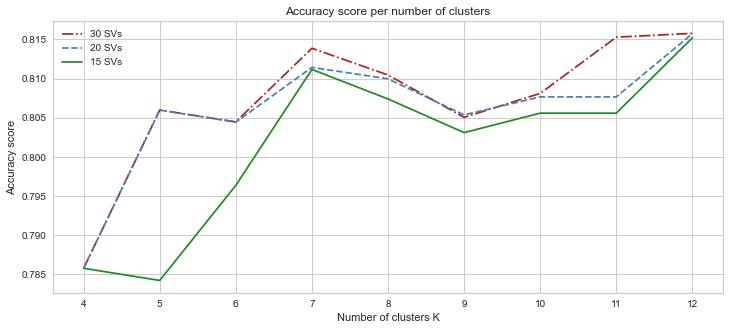

In [23]:
plot_accuracies(4, 13, [acc_mmscaled_all_svd_30, acc_mmscaled_all_svd_20, acc_mmscaled_all_svd_15], ['30 SVs', '20 SVs', '15 SVs'])

use all available features, **one-hot encode the categorical ones**

In [24]:
drop_enc = OneHotEncoder(drop='first')

train_ohe = drop_enc.fit_transform(train_df_cat)
test_ohe = drop_enc.transform(test_df_cat)

In [25]:
train_full = np.concatenate((train_df_num_scaled, train_ohe.todense()), axis=1)
test_full = np.concatenate((test_df_num_scaled, test_ohe.todense()), axis=1)

Service has very high cardinality, test results if the column is omitted 

In [26]:
train_df_cat = train_df[['protocol_type', 'flag']]
test_df_cat = test_df[['protocol_type', 'flag']]

# initialize the encoder again
drop_enc = OneHotEncoder(drop='first')
train_ohe = drop_enc.fit_transform(train_df_cat)
test_ohe = drop_enc.transform(test_df_cat)

train_full_no_serv = np.concatenate((train_df_num_scaled, train_ohe.todense()), axis=1)
test_full_no_serv = np.concatenate((test_df_num_scaled, test_ohe.todense()), axis=1)

In [27]:
acc_mmscaled_all_ohe = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_full , test_df=test_full, y_act=y_act_int)
acc_mmscaled_all_no_serv= kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_full_no_serv , test_df=test_full_no_serv, y_act=y_act_int)

100%|██████████| 9/9 [00:50<00:00,  5.61s/it]


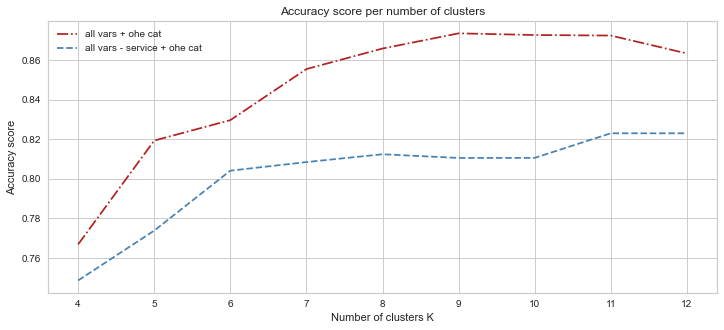

In [28]:
plot_accuracies(4, 13, [acc_mmscaled_all_ohe, acc_mmscaled_all_no_serv], ['all vars + ohe cat', 'all vars - service + ohe cat'])

The train set is quite large and does not let for much testing of different algorithms as they would require a lot of time to run.  
Following, the results of Kmeans accuracy will be tested against a model that is fit on **50% and 25% of the available training data**.

In [29]:
# use 50% of the train set 
X_train, _ = train_test_split(train_df, test_size=0.50, random_state=58)

train_df_num_50 = X_train[[col for col in train_df.columns if col not in cat_columns]]
train_df_cat_50 = X_train[cat_columns]

scaler = MinMaxScaler()
train_df_num_50 = scaler.fit_transform(train_df_num_50)

In [30]:
# use 25% of the train set 
X_train, _ = train_test_split(train_df, test_size=0.75, random_state=58)

train_df_num_25 = X_train[[col for col in train_df.columns if col not in cat_columns]]
train_df_cat_25 = X_train[cat_columns]

scaler = MinMaxScaler()
train_df_num_25 = scaler.fit_transform(train_df_num_25)

In [31]:
acc_mmscaled_num_50 = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_num_50 , test_df=test_df_num_scaled, y_act=y_act_int)
acc_mmscaled_num_25= kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_df_num_25 , test_df=test_df_num_scaled, y_act=y_act_int)

100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


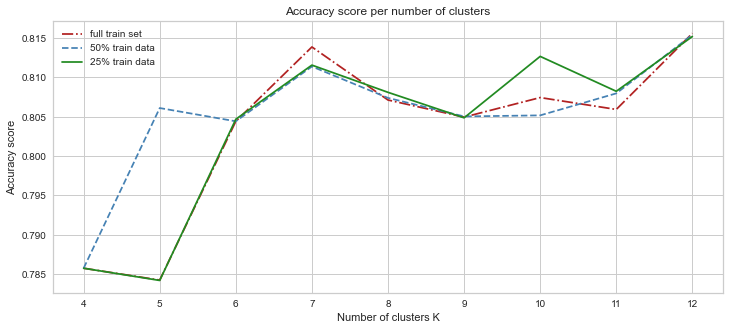

In [32]:
plot_accuracies(4, 13, [acc_mmscaled_all_num, acc_mmscaled_num_50, acc_mmscaled_num_25], ['full train set', '50% train data', '25% train data'])

There seems to be no much change in the accuracy of clusters when using reduced train examples.  
Run another train of reduced data along with one hot encoded categorical data.

In [33]:
drop_enc = OneHotEncoder(drop='first')

train_ohe = drop_enc.fit_transform(train_df_cat_50)
test_df_cat = test_df[cat_columns]
test_ohe = drop_enc.transform(test_df_cat)

train_full_50 = np.concatenate((train_df_num_50, train_ohe.todense()), axis=1)
test_full_50 = np.concatenate((test_df_num_scaled, test_ohe.todense()), axis=1)

In [34]:
drop_enc = OneHotEncoder(drop='first')

train_ohe = drop_enc.fit_transform(train_df_cat_25)
test_ohe = drop_enc.transform(test_df_cat)

train_full_25 = np.concatenate((train_df_num_25, train_ohe.todense()), axis=1)
test_full_25 = np.concatenate((test_df_num_scaled, test_ohe.todense()), axis=1)

In [35]:
acc_mmscaled_all_50 = kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_full_50 , test_df=test_full_50, y_act=y_act_int)
acc_mmscaled_all_25= kmean_accuracy_at_k(min_k=4, max_k=13, train_df=train_full_25 , test_df=test_full_25, y_act=y_act_int)

100%|██████████| 9/9 [00:23<00:00,  2.66s/it]


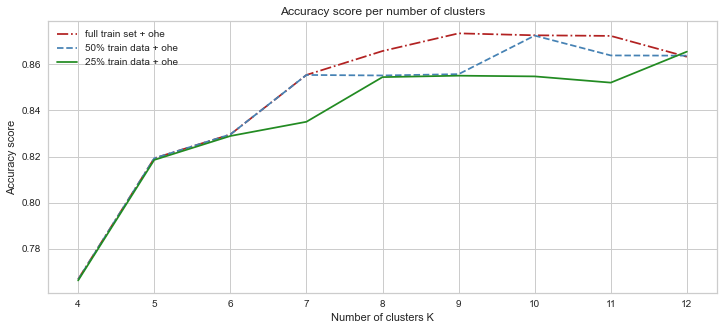

In [36]:
plot_accuracies(4, 13, 
                [acc_mmscaled_all_ohe, acc_mmscaled_all_50, acc_mmscaled_all_25], 
                ['full train set + ohe', '50% train data + ohe', '25% train data + ohe'])

In [39]:
### HDBSCAN -->slow
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(train_df_num_25)
print(f'The algorithm predicts {clusterer.labels_.max()} clusters using HDBSCAN!')

The algorithm predicts 180 clusters using HDBSCAN!


In [41]:
yhat, strengths = hdbscan.approximate_predict(clusterer, test_df_num_scaled)
pd.Series(yhat).value_counts()

-1      11182
 10      3055
 54      1222
 155      883
 90       557
        ...  
 7          1
 99         1
 19         1
 104        1
 100        1
Length: 156, dtype: int64

Most of the values though, are clustered as **noise** (-1)

### aglomerative clustering   
--> very slow, even when using 25% of the training dataset and the fast implementation (O(N^2)) from fastcluster.  
No results, even after 30 minutes.

In [42]:
# clusterer = linkage(train_df_num_25, method='ward')